# Self-Driving Car Engineer Nanodegree

## P2: Build a Traffic Sign Recognition Classifier | Deep Learning

### Data Exploration

#### Load and Setup Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from scipy import misc

import time
import pickle
import random
import classifier

from scipy.stats import describe
from six.moves import xrange

%pylab
%matplotlib inline
plt.style.use('ggplot')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


/home/mimoralea/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Loading the data

In [2]:
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

#### Data Statistics

In [3]:
n_classes = len(np.unique(y_train))

n_train = X_train.shape[0]
n_test = X_test.shape[0]

image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### Visualize sample images

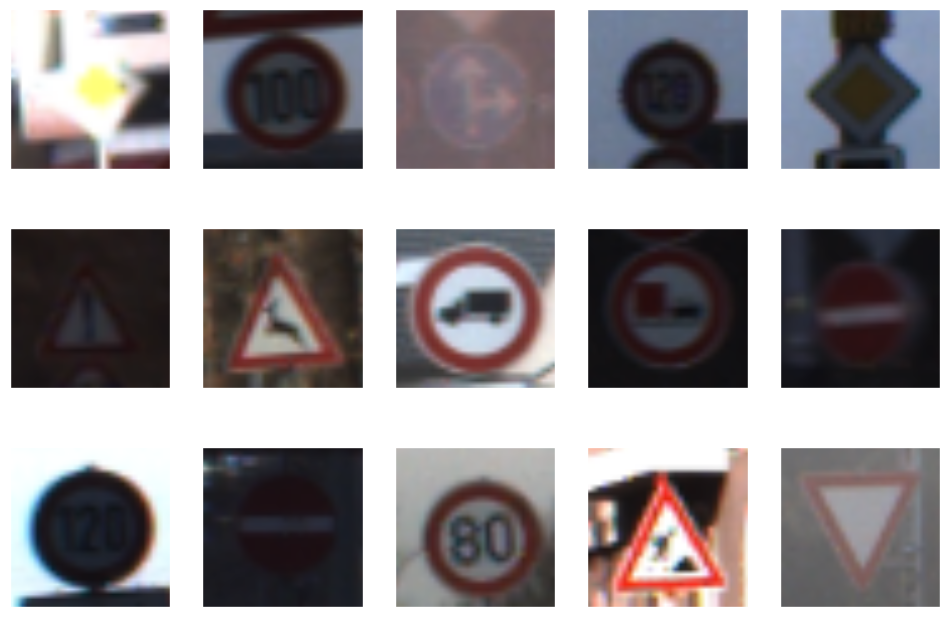

In [4]:
fig = plt.figure(figsize=(12,8))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(X_train[np.random.randint(n_train)])

#### Most and least images per class

(array([  210.,  2220.,  2250.,  1410.,  1980.,  1860.,   420.,  1440.,
         1410.,  1470.,  2010.,  1320.,  2100.,  2160.,   780.,   630.,
          420.,  1110.,  1200.,   210.,   360.,   330.,   390.,   510.,
          270.,  1500.,   600.,   240.,   540.,   270.,   450.,   780.,
          240.,   689.,   420.,  1200.,   390.,   210.,  2070.,   300.,
          360.,   480.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 42 Patch objects>)

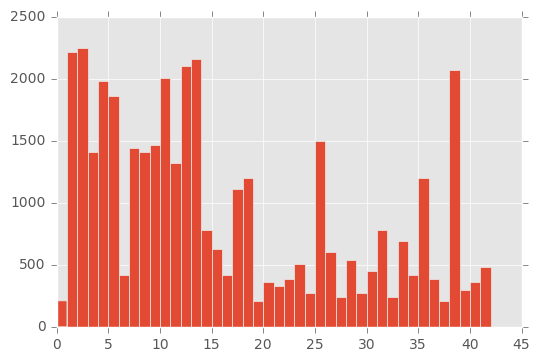

In [100]:
plt.hist(y_train, bins=range(n_classes))

In [101]:
sign_strings = pd.read_csv('signnames.csv', index_col=0)
least_seen = [0,38,39,40,41,42]
most_seen = [1,2,4,5,12,13]

In [102]:
sign_strings.loc[least_seen,:]

,SignName
ClassId,
0,Speed limit (20km/h)
38,Keep right
39,Keep left
40,Roundabout mandatory
41,End of no passing
42,End of no passing by vechiles over 3.5 metric ...


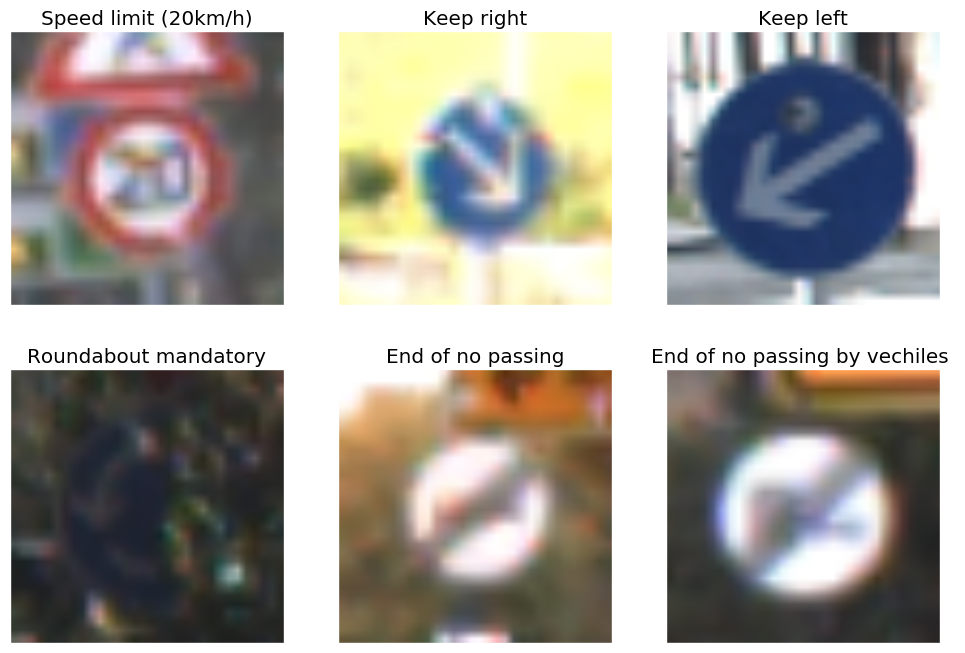

In [70]:
fig = plt.figure(figsize=(12,8))

for i, c in enumerate(least_seen):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[c,'SignName'][:30])
    idx = np.squeeze(np.argwhere(y_train == c))[0]
    ax.imshow(X_train[idx])

In [72]:
sign_strings.loc[most_seen,:]

,SignName
ClassId,
1,Speed limit (30km/h)
2,Speed limit (50km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
12,Priority road
13,Yield


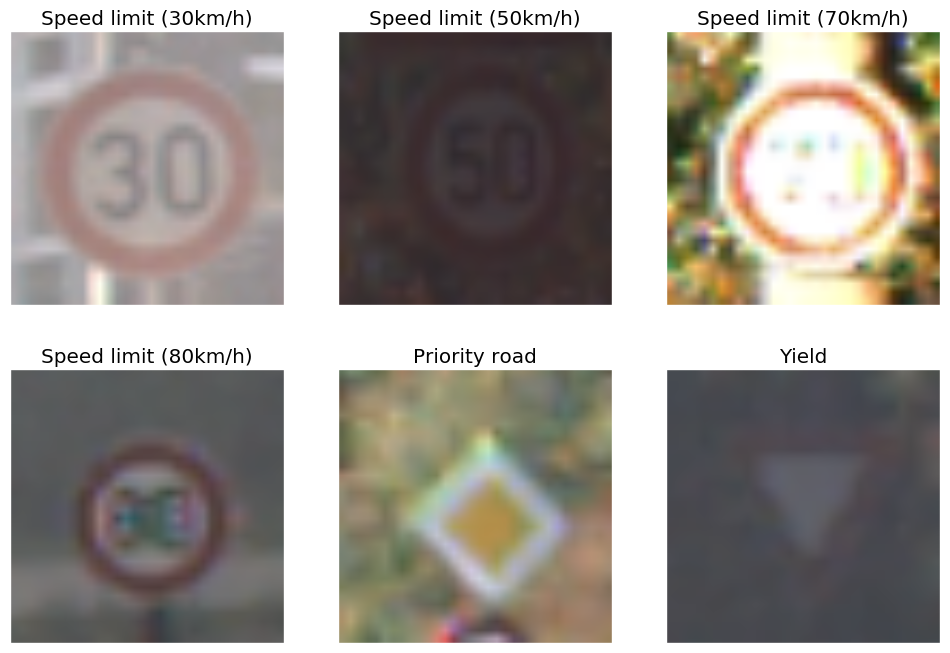

In [73]:
fig = plt.figure(figsize=(12,8))

for i, c in enumerate(most_seen):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(sign_strings.loc[c,'SignName'][:30])
    idx = np.squeeze(np.argwhere(y_train == c))[0]
    ax.imshow(X_train[idx])

#### Mean and Std images

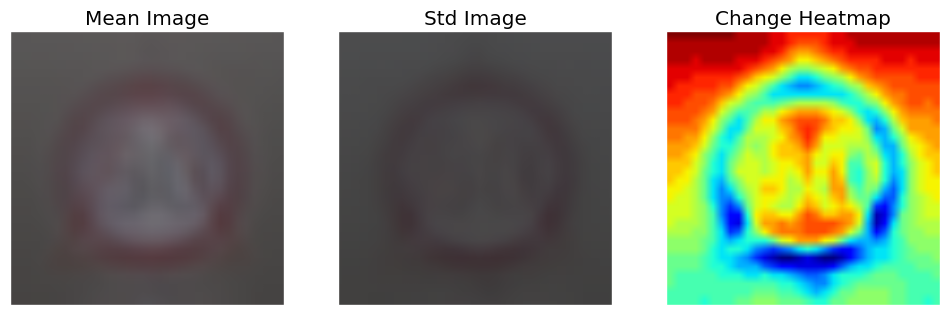

In [13]:
mean_img = np.mean(X_train, axis=0)
std_img = np.std(X_train, axis=0)
heat_img = np.mean(std_img, axis=2)

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(1, 3, 1)
ax1.grid(False)
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])
ax1.set_title('Mean Image')
ax1.imshow(mean_img.astype(np.uint8))

ax2 = fig.add_subplot(1, 3, 2)
ax2.grid(False)
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])
ax2.set_title('Std Image')
ax2.imshow(std_img.astype(np.uint8))

ax3 = fig.add_subplot(1, 3, 3)
ax3.grid(False)
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
ax3.imshow(std_img.astype(np.uint8))
ax3.set_title('Change Heatmap')
ax3.imshow(heat_img.astype(np.uint8))

#### Other...

### Model Design

#### Overall Design

![title](imgs/overall-architecture.png)

#### Images Preprocessing Pipeline 

In [28]:
def augment_image(img):
    img = tf.image.central_crop(img, np.random.uniform(0.6, 1.0))
    img = tf.image.random_saturation(img, lower=0, upper=10)
    img = tf.image.random_brightness(img, max_delta=0.8)
    img = tf.image.random_contrast(img, lower=0, upper=10)
    img = tf.image.per_image_whitening(img)
    return img
    
def augment_images(images):
    _, img_height, img_width, _ = images.get_shape().as_list()
    images = tf.map_fn(lambda img: augment_image(img), images)
    images = tf.image.rgb_to_grayscale(images)
    images = tf.image.resize_images(images, (img_height, img_width),
                                    method=0,
                                    align_corners=False)
    return images

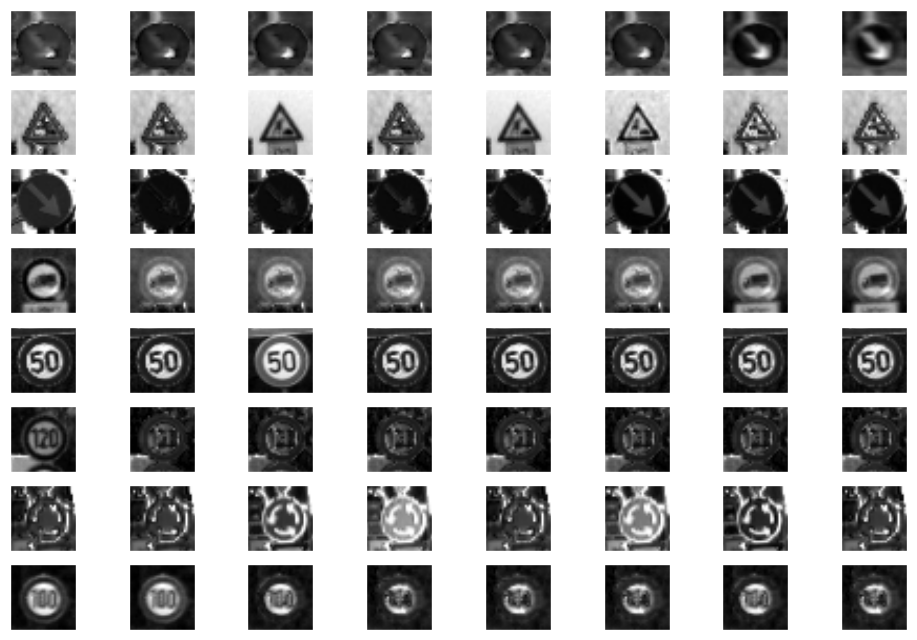

In [29]:
with tf.Session() as sess:
    img = X_train[np.random.randint(n_train)]
    imgs = []
    for i in range(64):
        if i % 8 == 0 :
            img = X_train[np.random.randint(n_train)]
        imgs.append(img)
    img_placeholder = tf.placeholder(tf.float32, shape=[64, 32, 32, 3])
    images = augment_images(img_placeholder)
    images = sess.run(images, feed_dict={img_placeholder:imgs})

    fig = plt.figure(figsize=(12,8))
    for i in range(64):
        ax = fig.add_subplot(8, 8, i + 1)
        ax.grid(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(np.squeeze(images[i]), cmap='gray')

#### Convolutions And Poolings

![title](imgs/convolutions.png)

#### Neural Network Classifier Architecture

![title](imgs/fully-connected-neural-network.png)

### Model Implementation

#### Code Samples: Helper Functions

In [30]:
def _variable_on_cpu(name, shape, initializer):
    """Helper to create a Variable stored on CPU memory.
    Args:
        name: name of the variable
        shape: list of ints
        initializer: initializer for Variable
    Returns:
        Variable Tensor
    """
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def _variable_with_weight_decay(name, shape, stddev, wd):
    """Helper to create an initialized Variable with weight decay.
    Note that the Variable is initialized with a truncated normal distribution.
    A weight decay is added only if one is specified.
    Args:
        name: name of the variable
        shape: list of ints
        stddev: standard deviation of a truncated Gaussian
        wd: add L2Loss weight decay multiplied by this float. If None, weight
            decay is not added for this Variable.
    Returns:
        Variable Tensor
    """
    var = _variable_on_cpu(
            name,
            shape,
            tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

#### Code Samples: Convolutional and Pooling Layers

In [31]:
def convolutions(images):

    # conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 1, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        bias = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(bias, name=scope.name)

    # pool1
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                           padding='SAME', name='pool1')

    # norm1
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                      name='norm1')

    # conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        bias = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(bias, name=scope.name)

    # norm2
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, 
                      beta=0.75, name='norm2')

    # pool2
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], 
                           padding='SAME', name='pool2')
    return pool2

#### Code Samples: Deep Convolutional Network

In [32]:
def fully_connected_nn(pool2, keep_prob=0.4, n_classes = 43):
    # local3
    with tf.variable_scope('local3') as scope:
        # Move everything into depth so we can perform a single matrix multiply.
        dim = np.prod(pool2.get_shape().as_list()[1:])
        reshape = tf.reshape(pool2, [-1, dim])
        weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # local4
    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                              stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)

    # dropout
    local4_drop = tf.nn.dropout(local4, keep_prob)

    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [192, n_classes],
                                              stddev=1/192.0, wd=0.0)
        biases = _variable_on_cpu('biases', [n_classes],
                                  tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(local4_drop, weights), biases, name=scope.name)

    # normalized `sum(logits) == 1`
    softmax_normalized = tf.nn.softmax(softmax_linear)
    return softmax_normalized

#### Code Samples: Loss function

In [33]:
def loss_func(logits, labels):
    """Add L2Loss to all the trainable variables.
    Add summary for "Loss" and "Loss/avg".
    Args:
      logits: Logits from inference().
      labels: Labels from distorted_inputs or inputs(). 1-D tensor
              of shape [batch_size]
    Returns:
      Loss tensor of type float.
    """
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all of the weight
    # decay terms (L2 loss).
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

#### Code Samples: Training Step

In [34]:
def train_step(total_loss, global_step):
    """
    Create an optimizer and apply to all trainable variables. Add moving
    average for all trainable variables.
    Args:
      total_loss: Total loss from loss().
      global_step: Integer Variable counting the number of training steps
        processed.
    Returns:
      train_op: op for training.
    """
    # Variables that affect learning rate.
    num_batches_per_epoch = 50000 / 128
    decay_steps = int(num_batches_per_epoch * 350.0)

    # Decay the learning rate exponentially based on the number of steps.
    lr = tf.train.exponential_decay(0.05,
                                    global_step,
                                    decay_steps,
                                    0.1,
                                    staircase=True)
    # Calculate gradients.
    opt = tf.train.GradientDescentOptimizer(lr)
    grads = opt.compute_gradients(total_loss)

    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(0.9999, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')

    return train_op

#### Sample Code: Core Training Process 

In [35]:
def train_main():
    with tf.Graph().as_default():

        # Set variables
        global_step = tf.Variable(0, trainable=False)
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # Augment images batch
        process_op = augment_images(images_p)

        # Calculate the logits and loss
        pool2 = convolutions(process_op)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)
        loss = loss_func(logits, labels_p)

        # Create a training operation that updates the
        # network parameters
        train_op = train_step(loss, global_step)

        # Build an initialization operation to run below.
        init = tf.initialize_all_variables()

        # Start running operations on the Graph.
        sess = tf.Session(config=tf.ConfigProto(
            log_device_placement=False))
        sess.run(init)

        # Start the queue runners.
        tf.train.start_queue_runners(sess=sess)

        total_training_time = 0
        for step in xrange(1001):
            start_time = time.time()
            idx = np.random.randint(len(X_train), size=128)
            sess.run(train_op, feed_dict={images_p:X_train[idx],
                                          labels_p:y_train[idx],
                                          keep_prob_p:0.4})
            loss_value = sess.run(loss, feed_dict={images_p:X_train[idx],
                                                   labels_p:y_train[idx],
                                                   keep_prob_p:1.0})
            duration = time.time() - start_time
            total_training_time += duration
            assert not np.isnan(loss_value), 'Model diverged with loss = NaN'

            if step % 100 == 0:
                examples_per_sec = 128 / duration
                sec_per_batch = float(duration)

                format_str = ('%s: step %d, loss = %.2f (%.1f examples/sec; %.3f '
                              'sec/batch)')
                print (format_str % (datetime.datetime.now(), step, loss_value,
                                   examples_per_sec, sec_per_batch))

#### Sample Code: Sample Training Run 

In [25]:
train_main()

2016-11-23 18:37:40.671453: step 0, loss = 7.85 (100.8 examples/sec; 1.270 sec/batch)
2016-11-23 18:39:39.295877: step 100, loss = 7.69 (108.9 examples/sec; 1.176 sec/batch)
2016-11-23 18:41:40.971408: step 200, loss = 7.53 (105.3 examples/sec; 1.215 sec/batch)
2016-11-23 18:43:44.033189: step 300, loss = 7.38 (107.4 examples/sec; 1.192 sec/batch)
2016-11-23 18:45:47.427546: step 400, loss = 7.23 (93.6 examples/sec; 1.368 sec/batch)
2016-11-23 18:47:52.625701: step 500, loss = 7.07 (108.7 examples/sec; 1.178 sec/batch)
2016-11-23 18:49:53.581185: step 600, loss = 6.95 (109.2 examples/sec; 1.172 sec/batch)
2016-11-23 18:51:54.445363: step 700, loss = 6.83 (103.7 examples/sec; 1.234 sec/batch)
2016-11-23 18:53:55.568932: step 800, loss = 6.70 (106.1 examples/sec; 1.206 sec/batch)
2016-11-23 18:55:56.473748: step 900, loss = 6.57 (102.9 examples/sec; 1.244 sec/batch)
2016-11-23 18:57:59.600602: step 1000, loss = 6.40 (111.4 examples/sec; 1.149 sec/batch)


#### Comments About Training

Training time, etc

#### Visualizing Conv1 Filters

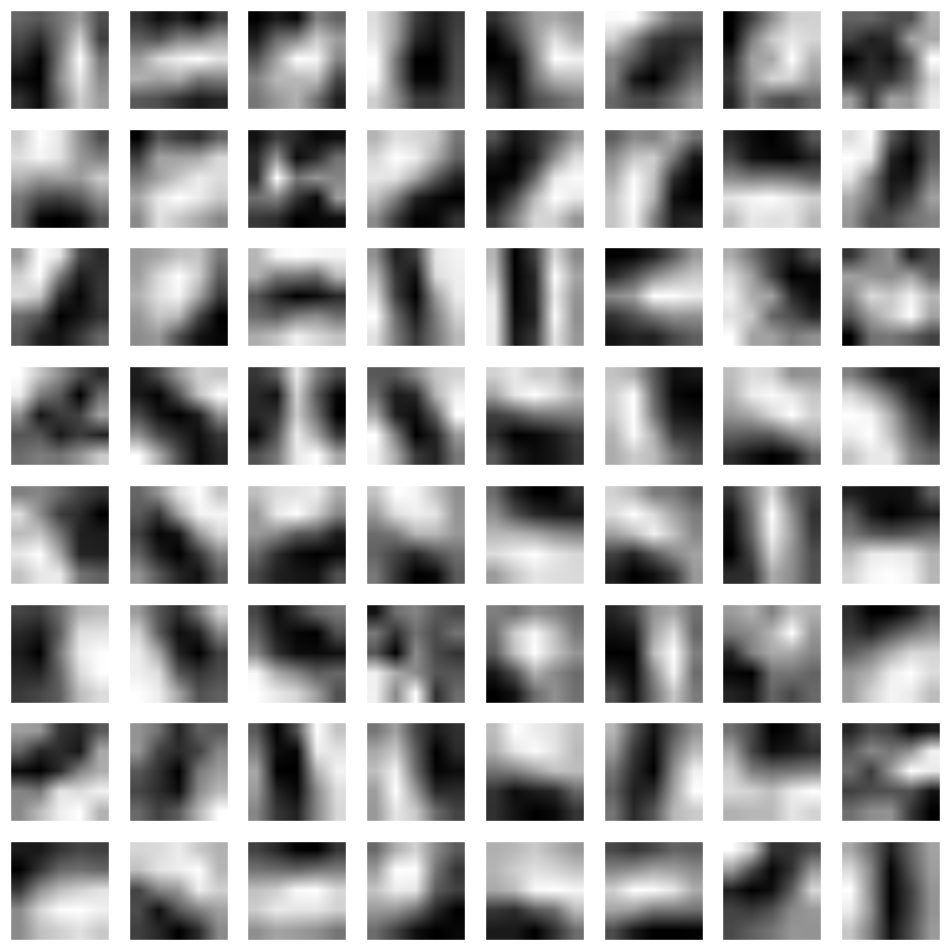

In [37]:
fig = plt.figure(figsize=(12,12))
arr = np.load('checkpoint_dir/conv1_weights_99000.npz')

# Get each 5x5 filter from the 5x5x1x32 array
for filter_ in range(arr.shape[3]):

    # Get the 5x5x1 filter:
    extracted_filter = arr[:, :, :, filter_]
    
    # Get rid of the last dimension (hence get 5x5):
    extracted_filter = np.squeeze(extracted_filter)

    # display the filter (might be very small - you can resize the window)
    ax = fig.add_subplot(8, 8, filter_ + 1)
    #ax.title('filter ' + str(filter_))
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(extracted_filter, cmap='gray')

#### Visualizing Conv2 Filters

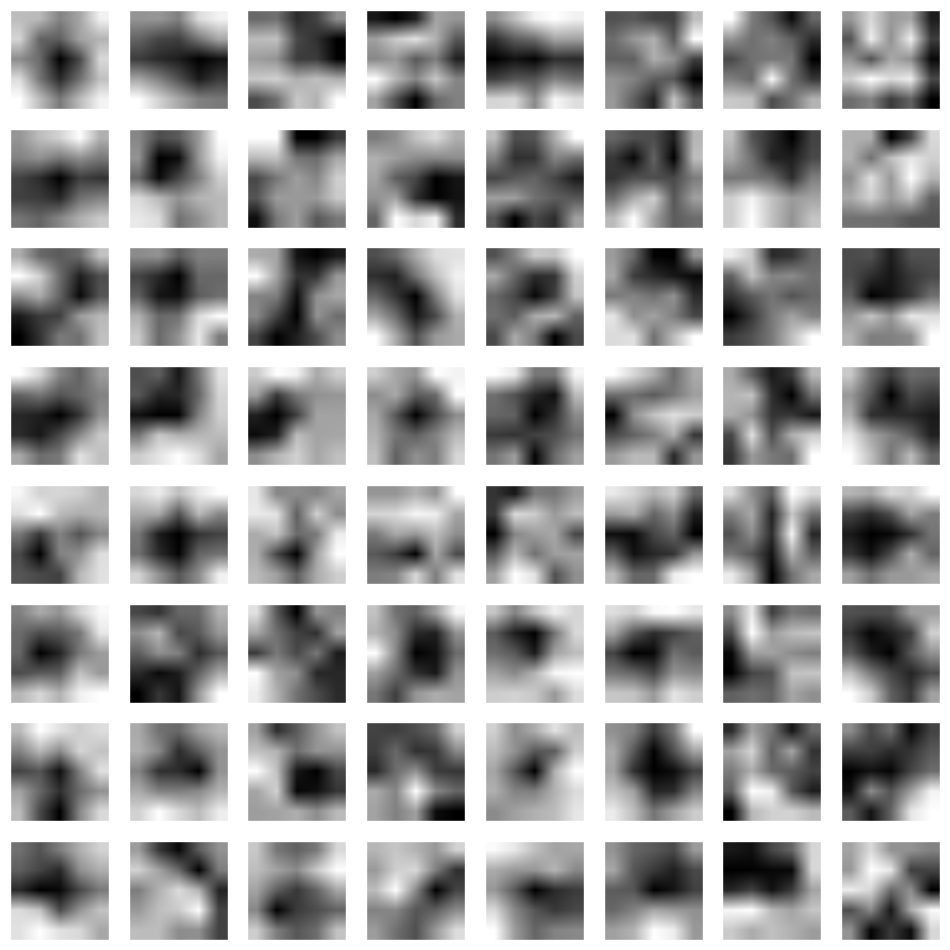

In [42]:
fig = plt.figure(figsize=(12,12))
arr = np.load('checkpoint_dir/conv2_weights_99000.npz')

# Get each 5x5 filter from the 5x5x1x32 array
for filter_ in range(arr.shape[3]):

    # Get the 5x5x1 filter:
    extracted_filter = arr[:, :, :, filter_]
    
    # Get rid of the last dimension (hence get 5x5):
    extracted_filter = np.mean(extracted_filter, axis=2)
    
    # display the filter (might be very small - you can resize the window)
    ax = fig.add_subplot(8, 8, filter_ + 1)
    ax.grid(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.imshow(extracted_filter, cmap='gray')

### Model Evaluation

#### Helper Functions

In [47]:
def eval_img(saver, logits, img, label, 
             images_p, labels_p, keep_prob_p):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('checkpoint_dir')
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        else:
            print('No checkpoint file found')
            return
        sign_strings = pd.read_csv('signnames.csv', index_col=0)
        slabel = label if label else [0]
        probs = sess.run(logits, feed_dict={images_p:img, 
                                            labels_p:slabel, 
                                            keep_prob_p:1.0})[0]
        sign_strings['prob'] = pd.Series(probs, index=sign_strings.index)
        sign_strings['correct'] = pd.Series(sign_strings.index.values == label, index=sign_strings.index)
        return sign_strings.sort_values(['prob', 'SignName'], ascending=[0, 1])


def eval_once(saver, top_k_op, X_test, y_test, 
              images_p, labels_p, keep_prob_p):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('checkpoint_dir')
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
        else:
            print('No checkpoint file found')
            return

        predictions = sess.run(top_k_op, feed_dict={images_p:X_test, 
                                                    labels_p:y_test, 
                                                    keep_prob_p:1.0})
        true_count = np.sum(predictions)
        precision = true_count / len(X_test)
    return precision

def get_precision(k = 1):
    with tf.Graph().as_default() as g:

        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        # Augment images batch
        process_op = augment_images(images_p)

        # Calculate the logits and loss
        pool2 = convolutions(process_op)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)

        # Calculate predictions.
        top_k_op = tf.nn.in_top_k(logits, labels_p, k)

        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            classifier.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)    
        precision = eval_once(saver, top_k_op, X_test, y_test, 
                              images_p, labels_p, keep_prob_p)
        print('%s: Test Set Top %s Precision %.3f' % (datetime.datetime.now(), k, precision))
        

def get_top_matches(image, label = None):
    with tf.Graph().as_default() as g:
        images_p = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
        labels_p = tf.placeholder(tf.int32, shape=[None])
        keep_prob_p = tf.placeholder(tf.float32)

        process_op = augment_images(images_p)

        pool2 = convolutions(process_op)
        logits = fully_connected_nn(pool2, keep_prob=keep_prob_p)
        
        # Restore the moving average version of the learned variables for eval.
        variable_averages = tf.train.ExponentialMovingAverage(
            classifier.MOVING_AVERAGE_DECAY)
        variables_to_restore = variable_averages.variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)  
        predictions = eval_img(saver, logits,
                               image, label,
                               images_p, labels_p, keep_prob_p)
        return predictions

#### Raw Accuracy

In [37]:
get_precision(k=1)

2016-11-23 20:30:34.644620: Test Set Top 1 Precision 0.743


#### Top 5 Accuracy

In [24]:
get_precision(k=5)

NameError: name 'get_precision' is not defined

#### Single Image Samples

                                                  SignName          prob  \
ClassId                                                                    
1                                     Speed limit (30km/h)  1.000000e+00   
4                                     Speed limit (70km/h)  4.702745e-09   
2                                     Speed limit (50km/h)  2.508604e-09   
5                                     Speed limit (80km/h)  3.169073e-10   
38                                              Keep right  2.425673e-10   
12                                           Priority road  7.496904e-11   
8                                    Speed limit (120km/h)  7.247093e-11   
18                                         General caution  3.532335e-11   
35                                              Ahead only  2.856456e-11   
9                                               No passing  1.807781e-11   
15                                             No vechiles  1.458226e-11   
6           

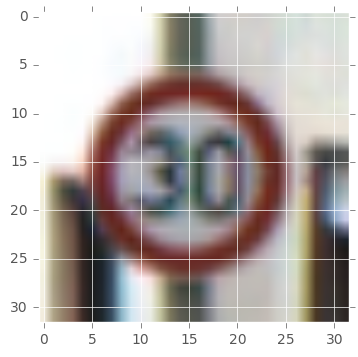

In [48]:
idx = 1032
img = X_train[idx]
label = y_train[idx]
matches = get_top_matches([img], [label])
print(matches)
plt.imshow(img)

#### Localized Images Results

In [84]:
localized_paths = ['imgs/local1.jpg', 'imgs/local2.jpg', 
                   'imgs/local3.jpg', 'imgs/local4.jpg',
                   'imgs/local5.jpg', 'imgs/local6.jpg',
                   'imgs/local7.jpg', 'imgs/local8.jpg',
                   'imgs/local9.jpeg', 'imgs/local10.jpg']
localized_imgs = np.array([misc.imresize(misc.imread(p), (32,32)) for p in localized_paths])

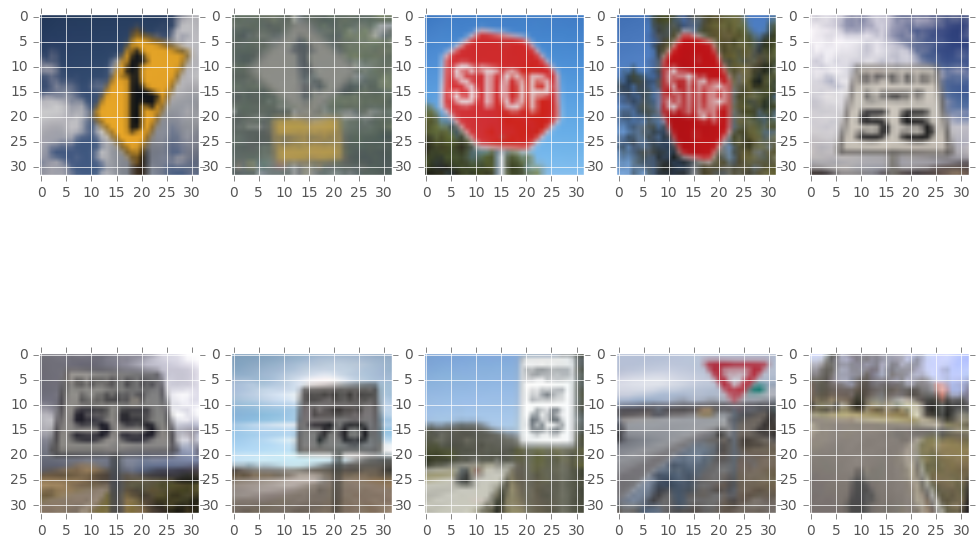

In [85]:
fig = plt.figure(figsize=(12,8))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    #ax.grid(False)
    #ax.get_xaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([])
    ax.imshow(localized_imgs[i])

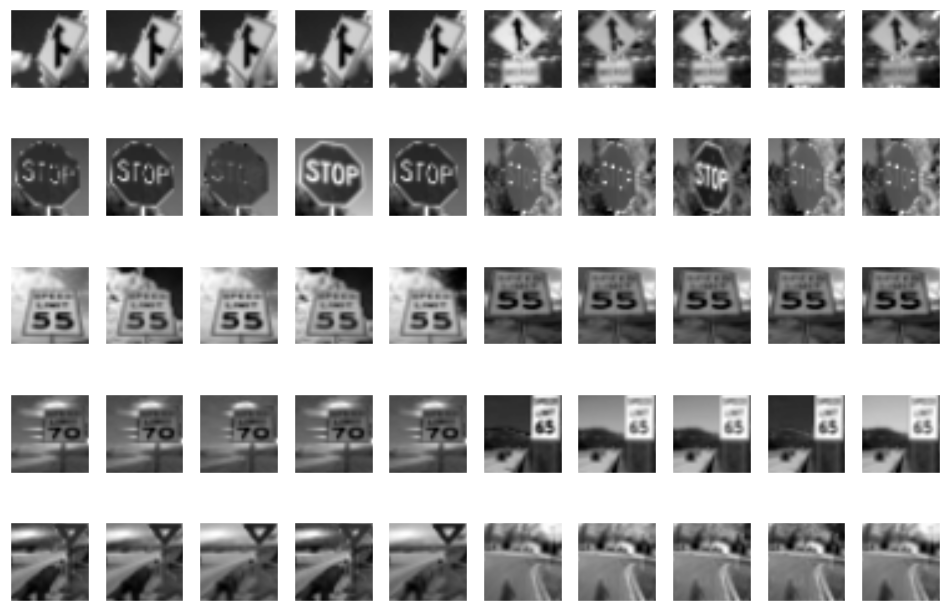

In [87]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        idx = -1
        imgs = []
        for i in range(50):
            if i % 5 == 0 :
                idx += 1
                img = localized_imgs[idx]
            imgs.append(img)
        img_placeholder = tf.placeholder(tf.float32, shape=[50, 32, 32, 3])
        images = augment_images(img_placeholder)
        images = sess.run(images, feed_dict={img_placeholder:imgs})

        fig = plt.figure(figsize=(12,8))
        for i in range(50):
            ax = fig.add_subplot(5, 10, i + 1)
            ax.grid(False)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.imshow(np.squeeze(images[i]), cmap='gray')

                                                  SignName      prob correct
ClassId                                                                     
10            No passing for vechiles over 3.5 metric tons  0.566632   False
38                                              Keep right  0.081543   False
14                                                    Stop  0.079523   False
13                                                   Yield  0.037052   False
4                                     Speed limit (70km/h)  0.022037   False
8                                    Speed limit (120km/h)  0.020774   False
25                                               Road work  0.020332   False
23                                           Slippery road  0.014763   False
34                                         Turn left ahead  0.013180   False
12                                           Priority road  0.010447   False
36                                    Go straight or right  0.010438   False

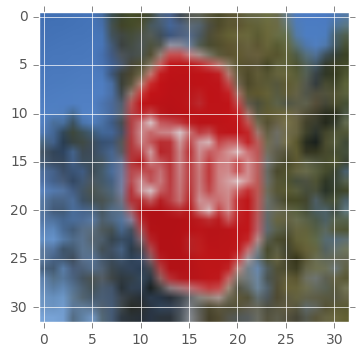

In [89]:
idx = 3
img = localized_imgs[idx]
matches = get_top_matches([img])
print(matches)
plt.imshow(img)

#### Video Stream Results

### Q&As

#### Question 1: 
_Describe the techniques used to preprocess the data._

#### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

#### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

#### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

#### Question 5


_What approach did you take in coming up with a solution to this problem?_

#### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._

#### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_

#### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

#### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._